# Develop negative log-likelihood with scaled inputs

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz

## Simulate measurements

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
delta = np.zeros(n)
alpha = np.zeros(m - 1)
eta = np.zeros(m - 1)

logv = np.log(sigma**2)
scale_logv = 1e-1 * np.ones(3)
scale_delta = thz.noiseamp(sigma, mu, ts)
scale_v = 1.0e-2

## Check gradient

In [3]:
_, grad_delta_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=np.ones(n),
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

_, grad_delta_tdnll_scaled = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_delta_nd = nd.Gradient(
    lambda _delta: thz.tdnll_scaled(
        x,
        logv,
        _delta,
        alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=np.ones(n),
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0],
    step=1e-6,
)(delta)

np.stack(
    (grad_delta_tdnll, grad_delta_tdnll_scaled / scale_delta, grad_delta_nd)
).T

array([[-1.78499301e+04, -1.78499301e+04, -1.78499136e+04],
       [ 3.34408331e+03,  3.34408331e+03,  3.34407730e+03],
       [-3.18976037e+04, -3.18976037e+04, -3.18975647e+04],
       [ 6.25507562e+01,  6.25507562e+01,  6.25536200e+01],
       [ 2.73178830e+04,  2.73178830e+04,  2.73178513e+04],
       [-7.20470280e+03, -7.20470280e+03, -7.20468844e+03],
       [-4.21790087e+04, -4.21790087e+04, -4.21789518e+04],
       [-2.82140739e+04, -2.82140739e+04, -2.82140365e+04],
       [ 2.53462945e+04,  2.53462945e+04,  2.53462625e+04],
       [ 4.91455018e+04,  4.91455018e+04,  4.91454464e+04],
       [ 1.68262230e+04,  1.68262230e+04,  1.68262022e+04],
       [ 5.52573815e+02,  5.52573815e+02,  5.52574263e+02],
       [ 8.62734944e+04,  8.62734944e+04,  8.62734033e+04],
       [ 1.29048234e+04,  1.29048234e+04,  1.29048127e+04],
       [ 5.01868231e+04,  5.01868231e+04,  5.01867727e+04],
       [ 2.79090884e+04,  2.79090884e+04,  2.79090620e+04],
       [ 1.27722077e+04,  1.27722077e+04

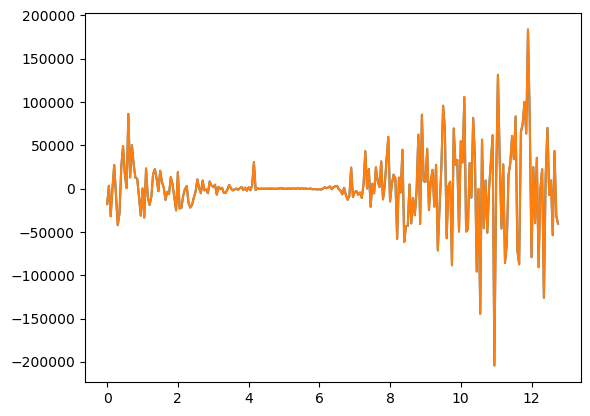

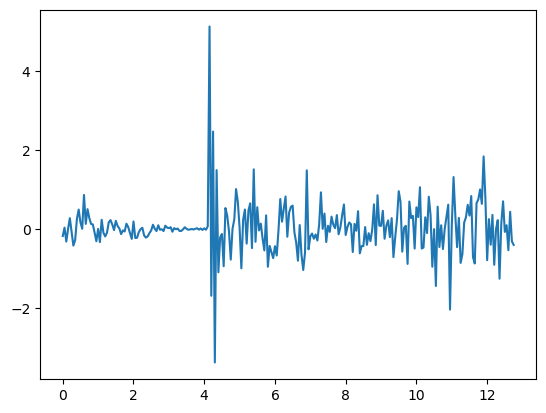

In [4]:
plt.plot(t, grad_delta_tdnll)
plt.plot(t, grad_delta_tdnll_scaled / scale_delta)
plt.show()
plt.plot(t, grad_delta_tdnll_scaled)
plt.show()

In [5]:
val, grad_logv_tdnll = thz.tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v),
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

val_scaled, grad_logv_tdnll_scaled = thz.tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v) / scale_logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=scale_logv,
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_logv_nd = nd.Gradient(
    lambda _logv: thz.tdnll_scaled(
        x,
        np.log(np.exp(_logv) / scale_v) / scale_logv,
        delta,
        alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=scale_logv,
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(logv)

print(f"{val=}")
print(f"{val_scaled=}")
np.stack(
    (grad_logv_tdnll, grad_logv_tdnll_scaled / scale_logv, grad_logv_nd)
).T

val=-1120.0566282420796
val_scaled=-1120.0566282420796


array([[33.65333722, 33.65333722, 33.65333722],
       [16.68960831, 16.68960831, 16.68960831],
       [30.42706181, 30.42706181, 30.42706181]])

In [6]:
_, grad_alpha_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=False,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_alpha_nd = nd.Gradient(
    lambda _alpha: thz.tdnll_scaled(
        x,
        logv,
        delta,
        _alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(alpha)

np.stack((grad_alpha_tdnll, grad_alpha_nd)).T

array([[ 6.14579370e+00,  6.14579370e+00],
       [ 4.25995097e+00,  4.25995097e+00],
       [ 3.66628809e-02,  3.66628810e-02],
       [ 5.30738008e+00,  5.30738008e+00],
       [ 9.60168835e+00,  9.60168835e+00],
       [ 1.94248475e+00,  1.94248475e+00],
       [-2.35733264e+00, -2.35733264e+00],
       [ 6.16109828e+00,  6.16109828e+00],
       [ 1.26372229e+00,  1.26372229e+00],
       [ 6.65283290e+00,  6.65283290e+00],
       [ 2.98736387e+00,  2.98736387e+00],
       [ 1.53145168e+01,  1.53145168e+01],
       [ 1.53666126e+01,  1.53666126e+01],
       [-3.27152519e+00, -3.27152519e+00],
       [-2.41295353e+00, -2.41295353e+00],
       [ 4.06611362e+00,  4.06611362e+00],
       [-2.71861290e+00, -2.71861290e+00],
       [ 1.66793339e+01,  1.66793339e+01],
       [ 4.14180499e+00,  4.14180499e+00],
       [ 8.16440035e+00,  8.16440035e+00],
       [ 1.34157812e+01,  1.34157812e+01],
       [ 2.05772588e+00,  2.05772588e+00],
       [ 6.54991588e+00,  6.54991588e+00],
       [ 1.

In [7]:
_, grad_eta_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=False,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_eta_nd = nd.Gradient(
    lambda _eta: thz.tdnll_scaled(
        x,
        logv,
        delta,
        alpha,
        _eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(eta)

np.stack((grad_eta_tdnll, grad_eta_nd)).T

array([[  -7.95043961,   -7.9504396 ],
       [ -68.83217984,  -68.83217983],
       [ -47.06069792,  -47.06069792],
       [ -53.43433844,  -53.43433843],
       [  28.77719651,   28.77719651],
       [  30.92402526,   30.92402526],
       [ -26.25958276,  -26.25958275],
       [   2.83066497,    2.83066497],
       [ -53.08906764,  -53.08906763],
       [  36.75375436,   36.75375437],
       [ -85.67448404,  -85.67448404],
       [-155.55677231, -155.55677231],
       [ -12.45752626,  -12.45752626],
       [ -41.21802195,  -41.21802194],
       [ -27.90398031,  -27.9039803 ],
       [ -97.64129928,  -97.64129928],
       [ 107.7591151 ,  107.7591151 ],
       [-126.67540415, -126.67540415],
       [  13.50237318,   13.5023732 ],
       [  -4.873489  ,   -4.873489  ],
       [ -52.94048313,  -52.94048313],
       [  55.93905431,   55.93905431],
       [-116.3443316 , -116.34433159],
       [  -6.23761421,   -6.23761421],
       [-135.9440647 , -135.94406469],
       [-187.27354405, -1

## Estimate noise parameters with revised NLL

In [8]:
result = thz.tdnoisefit(x.T, v0=sigma**2, ts=ts, fix_a=False, fix_eta=False)

In [9]:
print(result[2]["message"])

Optimization terminated successfully.


In [10]:
var_out = result[0]["var"] * m / (m - 1)
var_err = result[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 1.001e-10 ± 1.232e-09
Input: 0.0001	 Output: 9.722e-05 ± 0.00277
Input:  1e-06	 Output: 8.116e-07 ± 6.027e-05


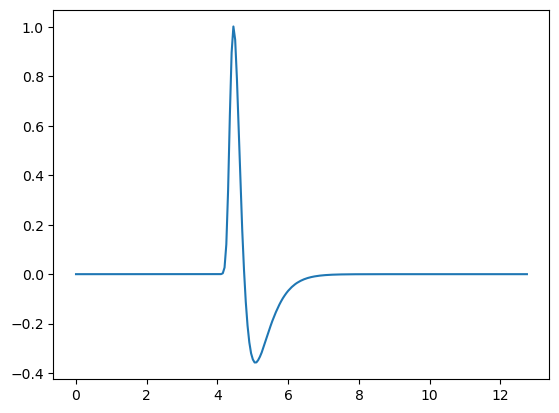

In [11]:
plt.plot(t, result[0]["mu"])
plt.show()

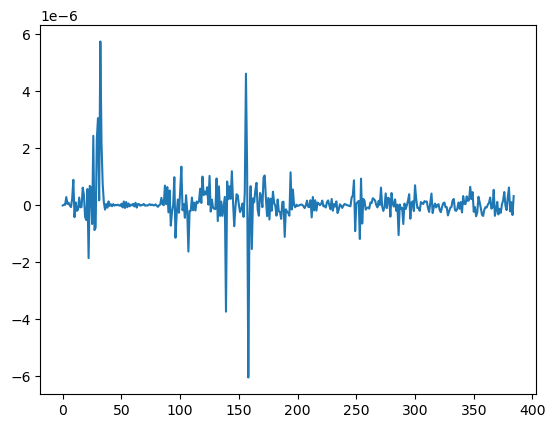

In [12]:
plt.plot(result[2]["grad"])
plt.show()